Source: 

Gomez, Charles, 2022, "Replication Data for: Leading countries in global science increasingly receive more citations than other countries doing similar research.", https://doi.org/10.7910/DVN/WCOINR, Harvard Dataverse.

In [1]:
import bz2
import pickle
import glob

import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm

PROJDIR = '/scratch/fl1092/followup-editors/race_citation_well/'
DATADIR = '../data/'

In [2]:
import matplotlib
from matplotlib import pyplot as plt

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
def YearlyKLDEdgelist(year_, phi_dictionary, discipline):
    
    try:

        # Source: https://stackoverflow.com/questions/24913425/pythonfast-efficient-implementation-of-the-kullback-leibler-divergence-for-mult
        def KLD_Matrix(phi_df_input):
            """
            Finds the pairwise Kullback-Leibler divergence
            matrix between all rows in X.

            Parameters
            ----------
            X : array_like, shape (n_samples, n_features)
                Array of probability data. Each row must sum to 1.

            Returns
            -------
            D : ndarray, shape (n_samples, n_samples)
                The Kullback-Leibler divergence matrix. A pairwise matrix D such that D_{i, j}
                is the divergence between the ith and jth vectors of the given matrix X.

            Notes
            -----
            Based on code from Gordon J. Berman et al.
            (https://github.com/gordonberman/MotionMapper)

            References:
            -----------
            Berman, G. J., Choi, D. M., Bialek, W., & Shaevitz, J. W. (2014). 
            Mapping the stereotyped behaviour of freely moving fruit flies. 
            Journal of The Royal Society Interface, 11(99), 20140672.
            """
            matrix_ = np.array(phi_df_input.T)
            matrix_[matrix_==matrix_.min()] = 1e-16
            matrix_ = (matrix_.T/ matrix_.sum(axis=1)).T

            matrix_log = np.log(matrix_)
            entropies = -np.sum(matrix_ * matrix_log, axis=1)
            D = np.matmul(-matrix_, matrix_log.T)
            D = D - entropies
            D = D / np.log(2)
            D *= (1 - np.eye(D.shape[0]))

            return D

        KLD_edgelist = pd.DataFrame(KLD_Matrix(phi_dictionary[year_]))
        KLD_edgelist.columns = phi_dictionary[year_].columns
        KLD_edgelist.index = KLD_edgelist.columns
        KLD_edgelist = (
            KLD_edgelist.unstack().reset_index()
            .rename(columns={"level_0":"Sender","level_1":"Receiver",0:"KLD"})
            .query("Sender!=Receiver")
        )
        KLD_edgelist["Vocas_Size"] = phi_dictionary[year_].shape[0]

        KLD_edgelist["Year"] = year_
        KLD_edgelist["Discipline"] = discipline

        return KLD_edgelist

    except Exception as e:
        print(e)
        return pd.DataFrame(columns={'Sender','Receiver'})

In [4]:
NLLDA_Min_Year = 1980 # 2001
NLLDA_Max_Year = 2017

In [5]:
def loadLLDA(disp):
    
    Yearly_NLLDA_Dict_Filename = DIR + f'llda/{disp}.pbz2' # f'llda_inf/{disp}.pbz2'

    f = bz2.BZ2File(Yearly_NLLDA_Dict_Filename, 'rb')
    Dictionary_of_NLLDA = {}

    for year in range(NLLDA_Min_Year,NLLDA_Max_Year+1):
        Dictionary_of_NLLDA[year] = pickle.load(f)
        
    return Dictionary_of_NLLDA

In [6]:
def extractPhi(Dictionary_of_NLLDA):
    
    phi_dictionary = {}

    # Start in 1980
    for year_ in range(1980,NLLDA_Max_Year+1):
        try:

            # Extract necessary parts from NLLDA Dictionary you loaded in
            phi_ = Dictionary_of_NLLDA[year_].phi()
            labelmap_ = Dictionary_of_NLLDA[year_].labelmap
            vocas_ = Dictionary_of_NLLDA[year_].vocas_id

            # Swap label and vocas dictionaries so that they are id number first
            # E.g., US:3 becomes 3:US, where 3 is the fourth column in Phi
            # E.g., Social Capital:34 becomes 34:Social Capital, the 35th row in Phi
            labelmap_ = {v:k for k, v in labelmap_.items()}
            vocas_ = {v:k for k, v in vocas_.items()}

            ### Create Phi DF where columns have country labels and rows have the vocabulary.
            ### Raw | Remove lowest value to zero for 'raw' 
            ### Normed | Remove lowest value and then renormalize sum to 
            ### 100% then renormalize to sum.
            ### *********************************
            ### Sanity Check | Compare column by column Term-to-Label presence matrix 
            ### NLLDA[year_].n_z_t with normalied phi_df_normed[label][phi_df_normed[label]>0]
            ### Once the lowest value is set to 0, the lengths should match. 
            ### Indicating that lowest value in non-normed phi_df reflects non-present terms.
            # Raw
            phi_df = pd.merge(pd.DataFrame.from_dict(vocas_,orient='index'),pd.DataFrame(phi_.T).rename(columns=labelmap_),left_index=True,right_index=True).set_index(0)
            phi_df = phi_df.apply(lambda x: x.replace(np.min(x),0),axis=0)
            # Normed

            # Collect and Save to a Dictionary
            phi_dictionary[year_] = phi_df

        except Exception as e:
            print("Error", year_, e)
            phi_dictionary[year_] = pd.DataFrame()
            
    return phi_dictionary

In [7]:
def citationDf(disp):
    
    citation_window = 5
    
    citation_df_input = pd.read_csv(DIR + f"citation/{disp}.csv.gz")
    citation_df_input = citation_df_input.rename(columns={"Citing_Race":"Sender","Cited_Race":"Receiver"})
    
    citation_df = (
        citation_df_input.query("Citing_Year-Cited_Year<=@citation_window")
        .drop(columns=["Citing_Year"])
        .rename(columns={"Cited_Year":"Year","number_of_cites":"Citations_ji"})
        .groupby(["Sender","Receiver","Year"]).agg({"Citations_ji":"sum"})
        .reset_index()
    )
    
    return citation_df

In [8]:
def calculateInDegree(KLD_citation_df, year_):

    G_InDelta_Citation_ij_Year = (
        nx.from_pandas_edgelist(
            KLD_citation_df.query("Year==@year_")
            .rename(columns={"Sender":"source","Receiver":"target","Delta_Citation_ij":"weight"})
            [["source","target","weight"]],edge_attr=True,create_using=nx.DiGraph()
        )
    )
    
    InDelta_Citation_ij_Year = dict(list(G_InDelta_Citation_ij_Year.in_degree(weight="weight")))
    InDelta_Citation_ij_Year = {
        country: degree/(len(InDelta_Citation_ij_Year)-1) for country, degree in InDelta_Citation_ij_Year.items()
    }
    InDelta_Citation_ij_Year = (
        pd.DataFrame.from_dict(InDelta_Citation_ij_Year,orient="index")
        .reset_index().rename(columns={"index":"Country",0:"InDelta_Citation_ij"})
    )
    
    InDelta_Citation_ij_Year["Year"] = year_
    
    return InDelta_Citation_ij_Year

In [9]:
def process(disp):
    
    try:
        Dictionary_of_NLLDA = loadLLDA(disp)
    except Exception as e:
        print(f"Skipping {disp}", e)
        return pd.DataFrame()
        
    phi_dictionary = extractPhi(Dictionary_of_NLLDA)
    
    KLD_edgelist_df = pd.concat(
        [YearlyKLDEdgelist(year_, phi_dictionary, disp) for year_ in range(NLLDA_Min_Year,NLLDA_Max_Year+1)],
        ignore_index=True, sort=False
    ).query("Sender!='common' & Receiver!='common'")
    
    if KLD_edgelist_df.shape[0] == 0:
        return pd.DataFrame()
    
    KLD_edgelist_df["KLD_CenterNormed"] = (
        KLD_edgelist_df.groupby('Year')[['KLD']].transform(lambda x: ((x.mean()-x)/x.std()))
    )
    
    citation_df = citationDf(disp)
    
    #assert(citation_df.shape[0] != 0)
    if citation_df.shape[0] ==0:
        return pd.DataFrame()
    
    KLD_citation_df = (
        pd.merge(
            KLD_edgelist_df.rename(columns={"Sender":"Receiver","Receiver":"Sender"}),
            citation_df, on=["Sender","Receiver","Year"], how="left")
        .fillna(0).query("Sender!='common' & Receiver!='common'")
    )

    KLD_citation_df = (
        pd.merge(
            KLD_citation_df,
            (
                KLD_edgelist_df
                .drop(columns=["KLD","Vocas_Size"])
                .rename(columns={"KLD_CenterNormed":"KLD_CenterNormed_T"})
            ), on=["Sender","Receiver","Year"], how="left")
        .fillna(0).query("Sender!='common' & Receiver!='common'")
    )
    
    KLD_citation_df = (
        pd.merge(
            KLD_citation_df,
            citation_df.rename(columns={"Sender":"Receiver","Receiver":"Sender","Citations_ji":"Citations_ij"}),
            on=["Sender","Receiver","Year"],how="left"
        )
        .fillna(0).query("Sender!='common' & Receiver!='common'")
    )
    
    KLD_citation_df["Citations_ij_CenterNormed"] = (
        KLD_citation_df.groupby('Year')[['Citations_ij']].transform(lambda x: (x-x.mean())/x.std())
    )
    KLD_citation_df["Delta_Citation_ij"] = (
        KLD_citation_df["Citations_ij_CenterNormed"] - KLD_citation_df["KLD_CenterNormed_T"]
    )
    
    try:
        InDelta_Citation_ij_df = pd.concat(
            [calculateInDegree(KLD_citation_df, year_) for year_ in range(NLLDA_Min_Year,NLLDA_Max_Year+1)]
        )
    except Exception as e:
        print(e)
        return pd.DataFrame()
    
    return InDelta_Citation_ij_df

In [10]:
import seaborn as sns

In [11]:
fields = pd.read_csv(DATADIR + 'citation_well/Fields.tsv',sep='\t')
fields = fields.Fields.values
len(fields)

292

# Plot

In [12]:
fieldCat = (
    pd.concat([
        pd.read_csv(DATADIR + 'citation_well/INPUT_MAG_FieldIDs_Domain.csv', usecols=['FieldID','Domain']),
        pd.read_csv(DATADIR + 'citation_well/INPUT_MAG_FieldIDs_Domain.csv', usecols=['FieldID','Domain_1']).rename(columns={'Domain_1':'Domain'})],
        ignore_index=True, sort=False
    )
    .rename(columns={'FieldID':'Field'})
    
    .dropna()
    .drop_duplicates()
    .assign(Domain = lambda df: df.Domain.apply(lambda x: 'Biomedical, Behavioral, and Ecological Sciences' if x=='Medicine' or x=='Life, Behavioral, and Ecological Sciences' else x))
    .assign(Domain = lambda df: df.Domain.apply(lambda x: 'Engineering and Computational Sciences' if x=='Engineering and Computer Science' else x))
)
fieldCat.shape, fieldCat.Field.nunique()

((311, 2), 250)

In [13]:
df = pd.read_csv(DATADIR + 'citation_well/DeltaCentrality.tsv', sep='\t')

In [16]:
COLOR = {
    'White': '#377eb8',
    'API': '#4daf4a',
    'Hispanic': '#ff7f00',
    'Black': '#e41a1c'
}

In [17]:
def plotCitationDistortion(CAT=None, lw=1, ytop=1, ybot=-1.2, ax=None):

    #if ax is not None: ax = plt.gca()

    if CAT is not None:
        toPlot = df.merge(fieldCat, on='Field')
        toPlot = toPlot.query(f'Domain == "{CAT}"')
    else:
        toPlot = df.copy()

    g = sns.lineplot(data=toPlot, x='Year', y='InDelta_Citation_ij', hue='Country', ax=ax, palette=COLOR, lw=lw)
    g.legend_.remove()
    
    ax.plot([1980, 2017], [0, 0], color='grey', ls='--', lw=0.5)

In [18]:
def styleAx(ax, ytop=1, ybot=-1.2):
    
    ax.set_ylim(ybot, ytop)
    
    ax.set_xlim(1980, 2017)
    ax.set_xticks([1980, 1990, 2000, 2010])
    
    ax.grid(visible=True, ls=':')
    ax.tick_params(length=0)
    
    ax.set_ylabel('')
    ax.set_xlabel('')    

# Plot

CPU times: user 13.8 s, sys: 408 ms, total: 14.2 s
Wall time: 13.9 s


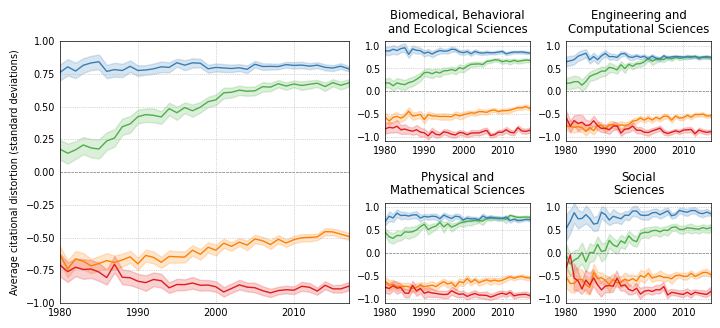

In [19]:
%%time

fig = plt.figure(figsize=(18*cm, 8*cm), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

ax0 = fig.add_subplot(spec[0:2, 0:2])

plotCitationDistortion(lw=1, ax=ax0)
styleAx(ax0, 1, -1)
ax0.set_ylabel('Average citational distortion (standard deviations)')


ax10 = fig.add_subplot(spec[0, 2])
plotCitationDistortion(CAT='Biomedical, Behavioral, and Ecological Sciences', lw=1, ax=ax10)
styleAx(ax10, 1.1, -1.1)
ax10.set_title('Biomedical, Behavioral\nand Ecological Sciences')

ax11 = fig.add_subplot(spec[0, 3])
plotCitationDistortion(CAT='Engineering and Computational Sciences', lw=1, ax=ax11)
styleAx(ax11, 1.1, -1.1)
ax11.set_title('Engineering and\nComputational Sciences')

ax20 = fig.add_subplot(spec[1, 2])
plotCitationDistortion(CAT='Physical and Mathematical Sciences', lw=1, ax=ax20)
styleAx(ax20, 1.1, -1.1)
ax20.set_title('Physical and\nMathematical Sciences')


ax21 = fig.add_subplot(spec[1, 3])
plotCitationDistortion(CAT='Social Sciences', lw=1, ax=ax21)
styleAx(ax21, 1.1, -1.1)
ax21.set_title('Social\nSciences')


plt.savefig(f'../figures/figure_4.pdf', bbox_inches = 'tight', pad_inches = 0)    